In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from matplotlib import rcParams
from matplotlib import font_manager as fm
from matplotlib.colors import ListedColormap

In [2]:
attr_data = torch.load('ftscores/eicu_test_extremalmask.pt')

In [3]:
label_resp = np.load('model_outputs/eICU/eicu_selfnorm_test.npy')

In [4]:
def process_labels(label0, shift_steps=12, all_zero=True):
    """
    Processes the input labels by reshaping, converting to binary, 
    and performing a forward shift.

    Parameters:
    - label0 (ndarray): The input label array.
    - shift_steps (int): The number of steps to shift the labels forward. 
                         Default is 144.

    Returns:
    - ndarray: The flattened, shifted label array.
    """
    # Reshape the input to a column vector
    label0_np_flat = label0.reshape(-1, 1)

    # Convert labels to binary (replace -1 with 0)
    if all_zero:
        labels_binary = np.where(label0_np_flat == -1, 0, label0_np_flat)
    else:
        labels_binary = label0_np_flat

    # Initialize the shifted labels array with zeros
    labels_shifted = np.zeros_like(labels_binary)

    # Perform the forward shift
    labels_shifted[shift_steps:] = labels_binary[:-shift_steps]

    # Flatten the shifted labels array and return
    return labels_shifted


def count_continuous_ones(binary_array):
    """
    Counts the number of continuous segments (or maps) of 1s in a binary array.

    Parameters:
    - binary_array (ndarray): The input binary array.

    Returns:
    - int: The number of continuous segments of 1s.
    """
    # Ensure the input is a numpy array
    binary_array = np.asarray(binary_array)

    # Identify where a segment of 1s starts (a 0 followed by a 1 or start of array)
    continuous_ones_count = np.sum((binary_array == 1) & (np.roll(binary_array, 1) != 1))

    return continuous_ones_count

In [5]:
def find_event_start(val):
    """ Finds the starting index of the first segment of continuous 1s. """
    try:
        start_index = np.where(val == 1)[0][0]
    except IndexError:
        start_index = -1
    return start_index

In [6]:
filtered_patients = []
cfs_counts = []
event_start_indices = []
original_indices = []

for idx, patient_data in enumerate(label_resp):
    val = process_labels(patient_data, 12, True)
    # val = patient_data
    val_count = count_continuous_ones(val)
    esi = find_event_start(val)
    if 0<val_count < 2 and esi==12:
        filtered_patients.append(val)
        cfs_counts.append(val_count)
        original_indices.append(idx)
        event_start_indices.append(esi)

In [7]:
# Lists to store the extracted data segments and additional info.
filtered_patient_data = []  # This will hold the raw data segments
filtered_labels = []        # Optionally, store the corresponding label segments
cfs_counts = []
original_indices = []
event_start_indices = []

# Assume that 'patient_data_list' is a list of your raw data arrays (one per patient)
# and 'label_resp' is the corresponding list of labels, or you can generate labels using process_labels.
for idx, patient_data in enumerate(label_resp):
    # Process the patient data to get the labels (for example, a binary vector)
    val = process_labels(patient_data, 12, True)
    
    # Count the continuous ones and find the event start index.
    val_count = count_continuous_ones(val)
    esi = find_event_start(val)
    
    # Only proceed if there is at least one continuous one and if we have at least 144 time steps before the event.
    if val_count > 0 and esi >= 12:
        # Extract a 144-timestep segment from the raw data ending at the event.
        # If esi == 144, this yields patient_data[0:144].
        # If esi > 144, this yields patient_data[esi-144:esi].
        data_segment = attr_data[idx,esi - 12:esi,:]
        
        # Optionally, also extract the corresponding label segment:
        # label_segment = labels[esi - 144:esi]
        
        # Save the extracted segments and information.
        filtered_patient_data.append(data_segment)
        filtered_labels.append(val)
        cfs_counts.append(val_count)
        original_indices.append(idx)
        event_start_indices.append(esi)

In [9]:
len(filtered_patient_data) ## must be 2197

2197

In [10]:
attr_filter = stacked_tensor = torch.stack(filtered_patient_data, dim=0)

In [11]:
attr_filter.shape

torch.Size([2197, 12, 63])

In [12]:
attr_data_filter_12 = attr_filter

In [13]:
attr_data_filter_12.shape

torch.Size([2197, 12, 63])

In [14]:
def longest_run(binary_sequence):
    """
    Computes the longest continuous sequence of 1's in a binary sequence.
    
    Parameters:
        binary_sequence (iterable): A list or array of 0s and 1s.
        
    Returns:
        int: The length of the longest consecutive sequence of 1's.
    """
    max_run = 0
    current_run = 0
    for value in binary_sequence:
        if value == 1:
            current_run += 1
            if current_run > max_run:
                max_run = current_run
        else:
            current_run = 0
    return max_run

def process_attribution_maps(attr_maps, threshold=0.8, run_duration_threshold=10):
    """
    Processes attribution maps to compute the binary mask and longest continuous runs (LCR) 
    for each patient and feature.
    
    Parameters:
        attr_maps (np.array): Attribution maps of shape (batch, 144, 231).
        threshold (float): The cutoff score to decide if a feature-time pair is highly important.
        run_duration_threshold (int): A value that can later be used for threshold-based ranking.
        
    Returns:
        tuple: (binary_maps, longest_runs)
            - binary_maps: Binary mask of shape (batch, 144, 231).
            - longest_runs: Array of shape (batch, 231) containing the LCR for each patient and feature.
    """
    batch, timesteps, features = attr_maps.shape
    
    # Step 1: Create a binary mask (1 if score > threshold, else 0)
    binary_maps = (attr_maps > threshold).astype(int)
    
    # Step 2: Compute the longest continuous run for each patient and feature.
    longest_runs = np.zeros((batch, features), dtype=int)
    for i in range(batch):
        for j in range(features):
            sequence = binary_maps[i, :, j]
            longest_runs[i, j] = longest_run(sequence)
    
    return binary_maps, longest_runs

def overall_temporal_feature_ranking(longest_runs, run_duration_threshold=10):
    """
    Computes overall feature rankings using three methods that consider all patients:
      1. Sum of longest continuous runs.
      2. Average longest continuous run.
      3. Count of patients with LCR >= run_duration_threshold.
    
    Parameters:
        longest_runs (np.array): Array of shape (batch, features) with LCR values.
        run_duration_threshold (int): The minimum LCR value to count a feature as high.
        
    Returns:
        dict: Contains rankings and associated aggregated metrics.
    """
    # Overall ranking metric 1: Sum of LCRs across all patients.
    overall_sum = np.sum(longest_runs, axis=0)
    ranking_overall_sum = np.argsort(-overall_sum)
    
    # Overall ranking metric 2: Average LCR across patients.
    average_run = np.mean(longest_runs, axis=0)
    ranking_average = np.argsort(-average_run)
    
    # Overall ranking metric 3: Count of patients with LCR >= run_duration_threshold.
    feature_threshold_counts = np.sum(longest_runs >= run_duration_threshold, axis=0)
    ranking_threshold = np.argsort(-feature_threshold_counts)
    
    return {
        'ranking_overall_sum': ranking_overall_sum,
        'overall_sum': overall_sum,
        'ranking_average': ranking_average,
        'average_run': average_run,
        'ranking_threshold': ranking_threshold,
        'feature_threshold_counts': feature_threshold_counts
    }

In [15]:
attr_maps = attr_data_filter_12.numpy().copy()

In [16]:
attr_maps.shape

(2197, 12, 63)

## new approach -- Temporal Cooocurence

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

In [18]:
# --- Helper functions ---
def longest_run(binary_sequence):
    """Compute the longest continuous sequence of 1's in a binary sequence."""
    max_run = 0
    current_run = 0
    for val in binary_sequence:
        if val == 1:
            current_run += 1
            if current_run > max_run:
                max_run = current_run
        else:
            current_run = 0
    return max_run

def process_attribution_maps(attr_maps, score_threshold=0.8):
    """
    Binarize the attribution maps (score > threshold) and compute the longest continuous run
    (LCR) for each feature for each patient.
    Returns an array of shape (batch, features) containing the LCR values.
    """
    batch, timesteps, features = attr_maps.shape
    binary_maps = (attr_maps > score_threshold).astype(int)
    longest_runs = np.zeros((batch, features), dtype=int)
    for i in range(batch):
        for j in range(features):
            longest_runs[i, j] = longest_run(binary_maps[i, :, j])
    return longest_runs

In [19]:
# --- Method 1 Implementation ---
def method1_hierarchical_clustering(longest_runs, run_duration_threshold=10, num_clusters=5):
    """
    Binarize features as 'active' if LCR >= run_duration_threshold.
    Compute the co-occurrence matrix and then the Jaccard distance between features.
    Use hierarchical clustering (average linkage) and display a dendrogram.
    """
    # Binarize: 1 if LCR >= run_duration_threshold
    binary_active = (longest_runs >= run_duration_threshold).astype(int)
    
    # Compute co-occurrence (for information; not directly used for clustering)
    cooccurrence = np.dot(binary_active.T, binary_active)

    np.fill_diagonal(cooccurrence, 0)
    
    # Compute pairwise Jaccard distances between feature columns.
    # pdist expects observations in rows so we pass binary_active.T.
    jaccard_distances = pdist(binary_active.T, metric='jaccard')
    
    # Hierarchical clustering using average linkage.
    Z = linkage(jaccard_distances, method='average')
    
    # Form flat clusters (optional) if you want a fixed number of clusters.
    clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
    
    # # Plot dendrogram for visualization.
    # plt.figure(figsize=(12, 6))
    # dendrogram(Z, labels=[f'F{i}' for i in range(binary_active.shape[1])], leaf_rotation=90)
    # plt.title("Hierarchical Clustering Dendrogram of Features")
    # plt.xlabel("Features")
    # plt.ylabel("Jaccard Distance")
    # plt.show()
    
    return clusters, cooccurrence


score_threshold = 0.9  # Score above which a value is considered high.
longest_runs = process_attribution_maps(attr_maps, score_threshold)

run_duration_threshold = 6  # Minimum LCR to mark a feature as active.
num_clusters = 5
clusters, cooccurrence = method1_hierarchical_clustering(longest_runs, run_duration_threshold, num_clusters)

In [21]:
import networkx as nx
import community as community_louvain  # python-louvain

In [22]:
node_names = ['O2SAT','PACO2','PHVAL','BASEX','BICAR','TOTCO','HCTCR','HEMOG','CHLOR','TEMPR','POTAS','SODIU','LACTA','GLUCO','HEART','IBPSY','IBPDY','IBPME','NBPSY','NBPDY','NBPME','RESPR','WBCNT','BASOS','EOSIN','LYMPH','MONOS','POLYS','BANDS','TROPT','CPKMB','ALBUM','TPROT','ANION','BUN01','CALCI','CREAT','FIBRG','INR01','PT001','PTT01','MCH01','MCV01','MCHC1','PLATE','RBC01','RDW01','ALT01','ALP01','AST01','AMYLA','BILIR','CPK01','GCS01','CRP01','WEIGH','UROUT','CVP01','CREUR','MAGNE','PHOSP','TIDAL','WBCUR']

In [93]:
np.random.seed(42)

In [24]:
# Build graph: add an edge between feature i and j if they co-occur in at least min_edge_weight patients.
num_features = 63
min_edge_weight = 2  # Adjust based on how strict you want the connectivity.

# Build the graph: add each feature as a node.
G = nx.Graph()
G.add_nodes_from(range(num_features))

# Add edges between features if their co-occurrence is at least min_edge_weight.
for i in range(num_features):
    for j in range(i + 1, num_features):
        weight = cooccurrence[i, j]
        if weight >= min_edge_weight:
            G.add_edge(i, j, weight=weight)


# # Also remove node 0 if it exists.
nodes_to_remove = [0,1,5,14,21,61,55]
nodes_present = [node for node in nodes_to_remove if node in G]
G.remove_nodes_from(nodes_present)

# Remove isolated nodes (no connections).
isolated_nodes = list(nx.isolates(G))
if isolated_nodes:
    G.remove_nodes_from(isolated_nodes)

# Remove nodes which only have a single connection.
nodes_single_connection = [node for node, degree in G.degree() if degree <=10]
if nodes_single_connection:
    G.remove_nodes_from(nodes_single_connection)

# Apply Louvain community detection on the pruned graph.
partition = community_louvain.best_partition(G, weight='weight',resolution=0.7, random_state=42)

In [25]:
pos = nx.kamada_kawai_layout(G)
communities = [partition[node] for node in G.nodes()]

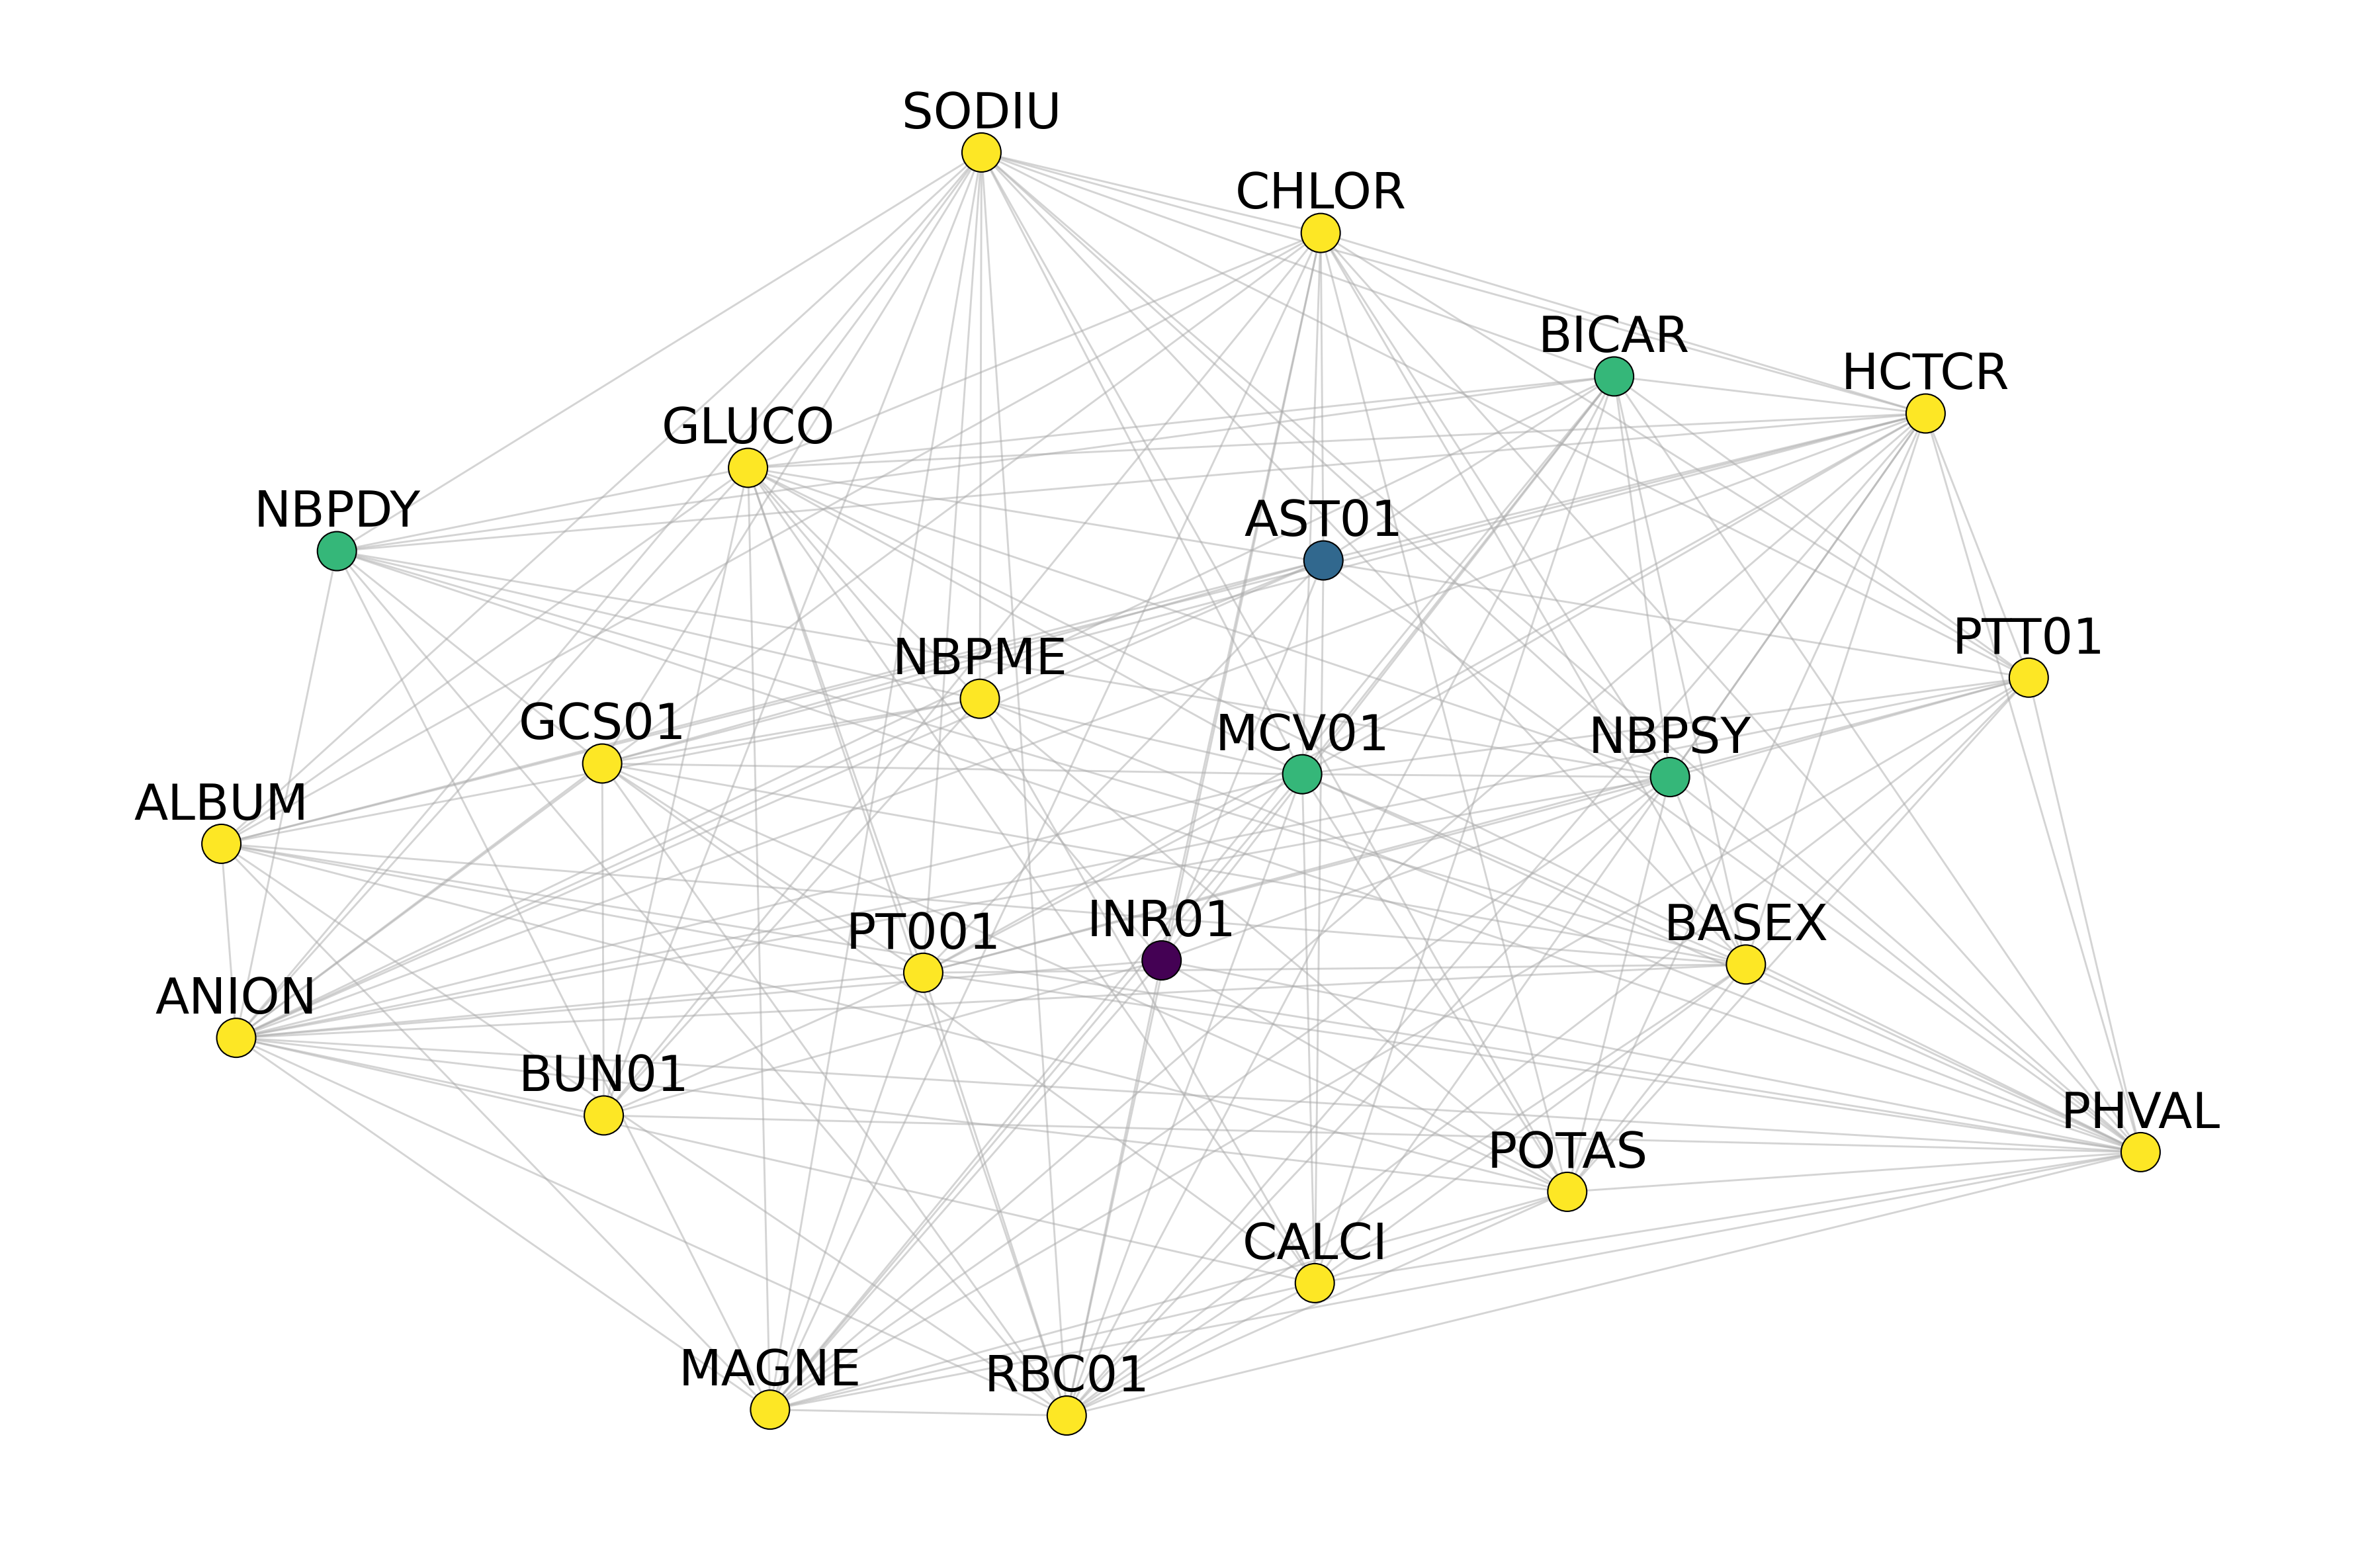

In [26]:
# Create a high-resolution figure.
plt.figure(figsize=(12, 8), dpi=300)

# Draw edges with a subtle gray color and a thin line width.
nx.draw_networkx_edges(
    G, pos,
    edge_color='#AAAAAA',
    alpha=0.5,
    width=0.7
)

# Draw nodes with:
# - A node size large enough for clarity.
# - A colormap based on community assignments.
# - Black outlines to better separate nodes.
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_color=communities,
    cmap=plt.get_cmap('viridis'),
    node_size=200,
    edgecolors='black',
    linewidths=0.5
)

# Create a label dictionary mapping node indices to node names.
label_dict = {node: node_names[node] for node in G.nodes()}

# Offset label positions: For each node, shift the label by a small vertical offset.
# The appropriate offset value depends on your graph scale—adjust as needed.
offset = 0.05  # Change this value to increase/decrease the offset
label_pos = {node: (x, y + offset) for node, (x, y) in pos.items()}

# Draw labels on the nodes using the offset positions.
nx.draw_networkx_labels(
    G, label_pos,
    labels=label_dict,
    font_size=18,
    font_color='black',
    font_family='sans-serif'
)

plt.axis('off')
plt.tight_layout()

plt.show()